# Gradient verification for the 1D - non reactive transport (diffusion + advection), permeability inversion from head observations 

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
import copy
import os
from pathlib import Path
from typing import Generator

import gstools as gs
import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pyrtid
from IPython.display import HTML
from matplotlib.animation import HTMLWriter
from pyrtid.utils import (
    NDArrayFloat,
    gen_random_ensemble,
)

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Check package/software versions

In [2]:
pyrtid.utils.show_versions()

- Create a directory to store the exported figures

In [3]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [4]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [5]:
nx = 40  # number of voxels along the x axis
ny = 1  # number of voxels along the y axis
dx = 10.0  # voxel dimension along the x axis
dy = 10.0  # voxel dimension along the y axis
nt = 30  # number of time steps
dt = 15 * 60 * 24  # timestep in seconds
c0 = 0  # general initial cocentration
# Hydro parameters
D0 = 1e-4  # general initial diffusion coefficient [m2/s]
k0 = 1e-4  # general permeability
w0 = 0.23  # general porosity [fraction]
wdiff = 1.0  # Diffusion
wadv = 1.0  # Advection
# Chemistry parameters
c0 = 0.0  # general initial concentration [molal]
c_inj = 1e-5  # molal

# Values for the x axis ()meters
x_positions_in_meters: NDArrayFloat = np.arange(nx) * dx + dx / 2

flow_regime = "stationary"
crank_flow = 1.0

- Three observation wells

In [6]:
observation_locations = [12, 28]

- Create an reference and an initial estimate distribution for the permebility

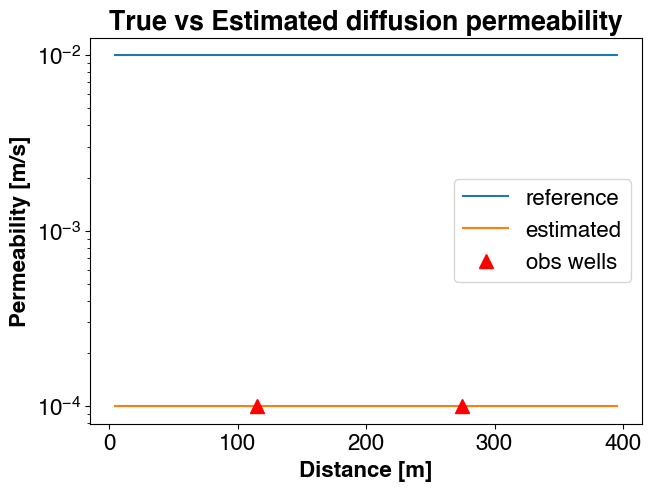

In [7]:
# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 6

min_val = 1e-4
max_val = 1e-2
# Compute the mean and the standard deviation that the distribution should have so that
# <99% of the values are between min and max ~ 6 sigmas
mean: float = (max_val + min_val) / 2.5
stdev: float = (max_val - min_val) / 3.0 / 2.0  # std ~ 1/6 of the distribution interval
len_scale: float = 5.0

perm_reference = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    seed=seed,
)[0, :, :, 0]


# Initial estimate = an homogeneous value
perm_estimate: NDArrayFloat = np.ones((nx, ny), dtype=np.float64) * min_val  # m2/s
perm_reference = np.ones((nx, ny)) * max_val  # m2/s

plotter = ngp.NestedGridPlotter()
ax = plotter.ax_dict["ax1-1"]

ax.set_xlabel("Distance [m]", fontweight="bold")
ax.set_ylabel("Permeability [m/s]", fontweight="bold")
ax.set_yscale("log")
ax.set_title("True vs Estimated diffusion permeability", fontweight="bold")
plotter.fig.set_facecolor("w")


ax.plot(x_positions_in_meters, perm_reference, label="reference")
ax.plot(x_positions_in_meters, perm_estimate, label="estimated")

# Add some vertical lines to indicate the well
for well_pos in observation_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        min_val,
        label="obs wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

plotter.add_axis_legend("ax1-1")

fname = "true_vs_estimated_initial_permeability"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Note: The assays take place over 5 days: for each day, on well inject or pump at 6 m3/h, while the head is observed at the others

### Forward problem in demonstrator

- For c_init, need to apply nx+1 in the case of the finite differences for the parameters because of the spatial discretization scheme (finite differences and finite volumes respectively).

In [8]:
# We define a function to easily generate a model.
# def create_base_model() -> RTModel:
#     return RTModel(nx + 1, ny, dx, dy, nt, dt, c0, D0, w0, k0, wadv=wadv, wdiff=wdiff)

- Create two models

In [9]:
# model_reference = create_base_model()
# model_estimate = create_base_model()
# # Exact diffusion
# model_reference.k = perm_reference.reshape(nx, 1)
# # Estimated diffusion
# model_estimate.k = perm_estimate.reshape(nx, 1)

- Run the models

In [10]:
# solver_true = RTSolver(model_reference)
# solver_true.solve()

# solver_estimate = RTSolver(model_estimate)
# solver_estimate.solve()

### Forward problem definition in HYTEC

- Top view

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 12)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax2-1"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        # "True model demonstrator": solver_true.model.fwd_conc[:, 0, :].T,
        # "A priori (estimate) model demonstartor": solver_estimate.model.fwd_conc[
        #     :, 0, :
        # ].T,
        "Reference model hytec": head_ref_hytec[:, 0, 0, :].T,
        "A priori (estimate) model hytec": head_estimate_hytec[:, 0, 0, :].T,
    },
)

fname = "head_ref_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Forward variables at the producer locations

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, node_id in enumerate(sorted(observation_locations)):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    # ax.plot(
    #     np.arange(nt) * dt / 3600 / 24,
    #     solver_true.model.fwd_conc[node_id, 0, :], label="Reference demonstrator", c="b"
    # )
    # ax.plot(
    #     np.arange(nt) * dt / 3600 / 24,
    #     solver_estimate.model.fwd_conc[node_id, 0, :],
    #     label="A priori demonstrator",
    #     c="r",
    # )
    ax.plot(
        grid_sample_times / 3600 / 24,
        head_ref_hytec[node_id, 0, 0, :],
        label="Reference Hytec",
        c="g",
    )
    ax.plot(
        grid_sample_times / 3600 / 24,
        head_estimate_hytec[node_id, 0, 0, :],
        label="A priori Hytec",
        c="k",
    )

plotter.fig.supxlabel("Time (days)")
plotter.fig.suptitle("Head at wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=0.0)

fname = "head_ref_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Static plot
# for ax_name in ["ax1-1", "ax1-2"]:
#     plotter.get_axis(ax_name).plot(model_reference.c_init, c="red", label="Initial")

# Animated plot
nb_frames = min(model_reference.time_params.nt, 30)

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "True": {
            "x": (np.arange(nx) + 0.5) * dx,
            "y": head_ref_hytec[:, 0, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "x": (np.arange(nx) + 0.5) * dx,
            "y": head_estimate_hytec[:, 0, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Hytec",
    xlabel="X [m]",
    ylabel="Head [m]",
)

# plotter.animated_multi_plot(
#     ax_name="ax1-2",
#     data={
#         "True": {"x": (np.arange(nx + 1) + 0.5) * dx, "y": solver_true.model.fwd_conc[:, 0, :], "kwargs": {"c": "blue"}},
#         "Estimated": {
#             "x": (np.arange(nx + 1) + 0.5) * dx, "y": solver_estimate.model.fwd_conc[:, 0, :],
#             "kwargs": {"c": "green", "linestyle": "--"},
#         },
#     },
#     nb_frames=nb_frames,
#     title="Pyrtid",
#     xlabel="X [m]",
# )


# plot the time
def get_time() -> Generator[str, None, None]:
    ts_btw_frames = int(head_estimate_hytec.shape[-1] / nb_frames)
    for frame in range(nb_frames):
        yield f"time = {grid_sample_times[ts_btw_frames * frame] / 3600:.3f} h"


for ax_name in ["ax1-1", "ax1-2"]:
    # Add some vertical lines to indicate the well
    for well_pos in observation_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx
            - dx / 2,  # Well pos + 1 because of indexing that starts at zero
            0.0,
            label="prod wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    plotter.plot_animated_text(
        ax=plotter.get_axis(ax_name),
        x=0.83,
        y=0.92,
        s=list(get_time()),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis(ax_name).transAxes,
        fontsize=14,
        fontweight="bold",
    )

    plotter.add_axis_legend(ax_name, loc="upper left")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname_html, writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

## Inversion

- Create a function to add some noise to the observations

In [ ]:
noise_std = 0.1  # This is an absolute value
rng = np.random.default_rng(2021)


def make_noisy(x: np.ndarray) -> np.ndarray:
    """Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return x + rng.normal(mean_noise, noise_std, x.shape)

- Check the intensity of the noise

In [ ]:
node_id = observation_locations[0]
plt.figure(facecolor="w")
plt.plot(head_ref_hytec[node_id, 0, 0, :])
plt.plot(make_noisy(head_ref_hytec[node_id, 0, 0, :]), marker=".", linestyle="none")

### Demonstrator


In [ ]:
# param = PyrtidAdjustableParameter(
#     name="permeability",
#     lbounds=min_val,
#     ubounds=max_val,
#     preconditioner=dminv.LogTransform()
# )

# from typing import Dict  # Just for linting

# observables: Dict[int, PyrtidObservable] = {}
# for node_id in observation_locations:
#     vals = make_noisy(solver_true.model.fwd_conc[node_id, 0, :])
#     timesteps = np.arange(vals.shape[0])

#     observables[node_id] = PyrtidObservable(
#         state_variable="tracer",
#         location=(slice(node_id, node_id + 1, 1), slice(None)),
#         timesteps=timesteps,
#         values=vals,
#         uncertainties=noise_std,
#     )

# # Create an executor
# executor = ScipyInversionExecutor(
#     model_estimate,
#     parameters_to_adjust=[param],
#     observables=list(observables.values()),
#     solver_config=ScipySolverConfig(),
# )

# # Compute the gradient both by finite difference and adjoint method
# # is_grad_ok = executor.is_gradient_correct(
# #     param,
# #     list(observables.values()),
# # )
# # print("Is the gradient correct: ", is_grad_ok)

### HYTEC

In [ ]:
# 1) Copy the base simulation
simu_inverse = copy.deepcopy(simu_estimate)
simu_inverse.update_root_and_name(new_root="simu_inverse", new_name="simu_inverse")

# 2) Add the observation wells
for count, ix in enumerate(observation_locations):
    x = (ix + 0.5) * dx
    zone_name = f"well_{ix}"
    # zone = simu_inverse.model.get_sub_model(hymd.GeometryModel).get_zone(name)

    vals = make_noisy(head_ref_hytec[ix, 0, 0, :])

    # Add the observables for the area
    obs = Observable(
        zone_name=zone.name,
        state_variable="head",
        units="m",
        timesteps=grid_sample_times,
        time_units="s",
        obs_type=ObservationType.GRID,
        values=vals,
        uncertainties=np.ones(vals.size) * noise_std,
        node_numbers=np.ones(vals.size) * ix,
    )
    simu_inverse.register_observable(
        zone_name, obs, obs_file_path=f"observables/{zone_name}_o.dat"
    )

# 3) Update the htc file with some options
inv_model = hymd.InverseModel(
    hymd.OptimizationStatus("enabled"),
    hymd.OptimizationSolverConfig(
        "lbfgsb", hymd.AdjointStateStatus("enabled"), hymd.FdGradientCheck("initial")
    ),
    hymd.AdjustedParameterConfig(
        "permeability",
        hymd.Lbound(min_val, units="m/s"),
        hymd.Ubound(max_val, units="m/s"),
        hymd.Preconditioner("logarithmic"),
    ),
)
simu_inverse.model.add_sub_item(inv_model)

# number of samples on the adjoint variables
simu_inverse.model.get_sub_model(hymd.SamplingModel).add_sub_item(
    hymd.AdjointGridSampling(nt)
)

# 4)Write the input files
simu_inverse.write_input_files()

runner.run(simu_inverse)

# 7) Read results
simu_inverse.read_hytec_results()  # This fails if not results have been written

- Plot the head field (to be sure it has been correctly reinitialized)

In [ ]:
inverse_heads_hytec = simu_inverse.handlers.results.extract_field_from_grid_res(
    field="head [m]", nx=nx
)

print(inverse_heads_hytec.shape)

plt.plot(inverse_heads_hytec[:, 0, 0, 0])
plt.plot(inverse_heads_hytec[:, 0, 0, -1])

- Plot the darcy velocities (to check that is has been correctly reinitialized)

In [ ]:
inverse_darcy_velocities_hytec = (
    simu_inverse.handlers.results.extract_field_from_grid_res(
        field="flowrate [m/s]", nx=nx
    )
)

plt.plot(inverse_darcy_velocities_hytec[:, 0, 0, 0], label="initial")
plt.plot(inverse_darcy_velocities_hytec[:, 0, 0, -1], label="final")
plt.ylabel("Flowrates [m/s]")
plt.legend()

plt.savefig(str(fig_save_path.joinpath("Darcy velocities check.png")))

- Extract the adjoint variables computed for the first gradient

In [ ]:
print(f"columns = {simu_inverse.handlers.results.optim_res.adjoint_var_columns}")

In [ ]:
adj_head_hytec = simu_inverse.handlers.results.extract_field_from_adj_var_res(
    field="adjoint-variable{T} [m]", nx=nx
)
adj_head_hytec.shape

In [ ]:
head_ref_hytec[:, 0, 0, -1]

In [ ]:
# plotter = ngp.AnimatedPlotter(
#     fig_params={"constrained_layout": True, "figsize": (12, 5)},
#     subplots_mosaic_params={
#         "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
#     },
# )

# # Static plot
# # for ax_name in ["ax1-1", "ax1-2"]:
# #     plotter.get_axis(ax_name).plot(model_reference.c_init, c="red", label="Initial")

# # Animated plot
# nb_frames = min(model_reference.time_params.nt, 30)

# plotter.animated_multi_plot(
#     ax_name="ax1-1",
#     data={
#         "Adjoint head": {
#             "x": (np.arange(nx) + 0.5) * dx,
#             "y": adj_head_hytec[:, 0, 0, :],
#             "kwargs": {"c": "green", "linestyle": "--"},
#         },
#     },
#     nb_frames=nb_frames,
#     title="Hytec",
#     xlabel="X [m]",
#     ylabel="Head [m]",
# )

# # plotter.animated_multi_plot(
# #     ax_name="ax1-2",
# #     data={
# #         "True": {"x": (np.arange(nx + 1) + 0.5) * dx, "y": solver_true.model.fwd_conc[:, 0, :], "kwargs": {"c": "blue"}},
# #         "Estimated": {
# #             "x": (np.arange(nx + 1) + 0.5) * dx, "y": solver_estimate.model.fwd_conc[:, 0, :],
# #             "kwargs": {"c": "green", "linestyle": "--"},
# #         },
# #     },
# #     nb_frames=nb_frames,
# #     title="Pyrtid",
# #     xlabel="X [m]",
# # )

# # plot the time
# def get_time() -> Generator[str, None, None]:
#     ts_btw_frames = int(adj_head_hytec.shape[-1] / nb_frames)
#     for frame in range(nb_frames):
#         yield f"time = {grid_sample_times[ts_btw_frames * frame] / 3600:.3f} h"


# for ax_name in ["ax1-1", "ax1-2"]:
#     # Add some vertical lines to indicate the well
#     for well_pos in observation_locations:
#         plotter.get_axis(ax_name).plot(
#             (well_pos + 1) * dx - dx / 2,  # Well pos + 1 because of indexing that starts at zero
#             0.0,
#             label="prod wells",
#             marker="^",
#             markersize=10,
#             c="r",
#             linestyle="none",
#         )

#     plotter.plot_animated_text(
#         ax=plotter.get_axis(ax_name),
#         x=0.83,
#         y=0.92,
#         s=list(get_time()),
#         horizontalalignment="center",
#         verticalalignment="center",
#         transform=plotter.get_axis(ax_name).transAxes,
#         fontsize=14,
#         fontweight="bold",
#     )

#     plotter.add_axis_legend(ax_name, loc="upper left")

# plotter.close()
# plotter.animate(nb_frames=nb_frames)
# # Save the animation locally on the computer
# fname_html = fig_save_path.joinpath("adjoint_head_animation.html")
# writer = HTMLWriter(fps=5, embed_frames=True)
# writer.frame_format = "svg"  # Ensure svg format
# plotter.animation.save(fname_html, writer=writer)

# # Extract the svg from the html file (for animation in Latex)
# ngp.extract_frames_from_embedded_html_animation(fname_html)

# # Display the animation
# HTML(fname_html.read_text())

### Results comparison

The adjoint concentrations should be quite the same both in shape and intensity.

In [ ]:
# plotter = ngp.NestedGridPlotter(
#     fig_params={"constrained_layout": True, "figsize": (10, 6)},
#     subplots_mosaic_params={
#         "fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)
#     },
# )

# ngp.multi_imshow(
#     axes=list(plotter.ax_dict.values()),
#     fig=plotter.fig,
#     data = {
#         # "Adj. var demonstrator": executor.rt_solver.inverse_model.adj_conc[:, 0, :].T,
#         "Adj. var HYTEC": adj_conc_hytec[:, 0, 0, :].T,
#     }
# )

# fname = "adjoint_concentrations_dem_vs_hytec_map"
# for format in ["png", "pdf"]:
#     plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

Let's check the adjoint variables at the three observation wells. Note that only the right one has been used as an adjoint source (node_id == 15).

In [ ]:
# plotter = ngp.NestedGridPlotter(
#     fig_params={"constrained_layout": True, "figsize": (8, 8)},
#     subplots_mosaic_params={
#         "fig0": dict(mosaic=[["ax1-1"], ["ax2-1"]], sharey=False, sharex=True)
#     },
# )

# for i, node_id in enumerate(production_locations):
#     ax = plotter.get_axis(f"ax{i + 1}-1")
#     x = (node_id + 0.5) * model_reference.dx
#     obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

#     ax.set_title(obs_well_name)
#     ax.plot(executor.rt_solver.inverse_model.adj_conc[node_id, 0, :], label="Adj. var. Demonstrator", c="g")
#     ax.plot(adj_conc_hytec[node_id, 0, 0, :], label="Adj. var. HYTEC", c="r")

# plotter.fig.suptitle("Tracer adjoint variable", fontweight="bold")
# plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

# fname = "adjoint_concentrations_dem_vs_hytec_1D"
# for format in ["png", "pdf"]:
#     plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Get the gradients by the adjoint method and finite differences

Finally, plot the gradients comparison.

In [ ]:
runner.run(simu_inverse)

# 7) Read results
simu_inverse.read_hytec_results()  # This fails if not results have been written

In [ ]:
# Get the HYTEC  Adj gradient
hytec_fd_gradient = simu_inverse.handlers.results.optim_res.fd_gradients[0]
hytec_adjoint_gradient = simu_inverse.handlers.results.optim_res.adjoint_gradients[0]

In [ ]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()

ax = plotter.get_axis("ax1-1")
# ax.plot(param.grad_adj_history[0] / 2, label="Adj. Demonstrator", c="b")
# ax.plot(
#     param.grad_fd_history[0] / 2, label="FD Demonstrator", c="r", linestyle="--"
# )
ax.plot(hytec_adjoint_gradient["value"] * 1e3, label="Adj. HYTEC", c="g")
ax.plot(hytec_fd_gradient["value"], label="FD HYTEC", c="k", linestyle="--")

ax.set_title("Gradient at first iteration")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)